# Downdrafts in Idealised Soundings

Thomas Schanzer z5310829  
School of Physics, UNSW  
October 2021

In this notebook, we create several idealised soundings and use them for downdraft calculations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '12'

import metpy.calc as mpcalc
from metpy.units import units
import metpy.constants as const
from metpy.units import concatenate
from metpy.plots import SkewT
from pint import set_application_registry
set_application_registry(units)

from scipy.integrate import simps, solve_ivp
from scipy.interpolate import interp1d

import sys
from os import mkdir
from os.path import exists
import shelve

sys.path.append('../../scripts/')
from environment import Environment
from thermo import moist_lapse, saturation_specific_humidity, dcape_dcin
from entraining_parcel import EntrainingParcel

## Creating the soundings
Following Chapter 9 (*The Atmospheric Boundary Layer*) of *Atmospheric Science : An Introductory Survey* by Wallace and Hobbs (2006):
- The boundary layer is usually 1-2 km thick with roughly uniform potential temperature and mixing ratio
- It is bounded above by a capping inversion in which temperature increases with height

We will use:
- A surface pressure of 1013.25 mbar and surface temperature 20C
- A 160 mbar thick (~1.5 km) boundary layer with dry adiabatic (uniform potential temperature) temperature profile and a uniform mixing ratio of 6 g/kg
- A 10 mbar thick (~100 m) capping inversion where temperature increases by 3C with height
- A moist adiabatic temperature profile in the rest of the atmosphere, with constant relative humidity

In [6]:
def idealised_sounding(relative_humidity, info='', name=''):
    """
    Creates an idealised sounding.
    
    Args:
        relative_humidity: Relative humidity above the boundary layer.
        info: Information to store with the sounding, e.g. date
            (optional)
        name: Short name for the sounding, e.g. 'Sydney' (optional).
        
    Returns:
        An Environment instance.
    """
    
    # generature temperature profile
    pressure = np.arange(1013.25, 200, -5)*units.mbar
    t_boundary_layer = mpcalc.dry_lapse(
        np.arange(1013.25, 1013.25 - 161, -5)*units.mbar, 20*units.celsius)
    t_capping = t_boundary_layer[-1] + [1.5, 3.0]*units.delta_degC
    t_remaining = mpcalc.moist_lapse(
        np.arange(1013.25 - 175, 200, -5)*units.mbar, t_capping[-1],
        reference_pressure=(1013.25 - 170)*units.mbar)
    temperature = concatenate([
        t_boundary_layer, t_capping, t_remaining,
    ])

    # generate dew point profile
    q_boundary_layer = mpcalc.specific_humidity_from_mixing_ratio(
        6e-3*units.dimensionless)
    dewpoint_boundary_layer = mpcalc.dewpoint_from_specific_humidity(
        np.arange(1013.25, 1013.25 - 161, -5)*units.mbar, t_boundary_layer,
        np.ones(t_boundary_layer.size)*q_boundary_layer)
    dewpoint_remaining = mpcalc.dewpoint_from_relative_humidity(
        t_remaining, np.ones(t_remaining.size)*relative_humidity)
    dewpoint_capping_top = mpcalc.dewpoint_from_relative_humidity(
        t_capping[-1], relative_humidity)
    dewpoint_capping = concatenate([
        (dewpoint_boundary_layer[-1].to(units.kelvin)
         + dewpoint_capping_top.to(units.kelvin))/2,
        dewpoint_capping_top,
    ])
    dewpoint = concatenate([
        dewpoint_boundary_layer, dewpoint_capping, dewpoint_remaining,
    ])
    
    temperature_interp = interp1d(
        pressure.m_as(units.pascal), temperature.m_as(units.kelvin),
        fill_value='extrapolate')
    dewpoint_interp = interp1d(
        pressure.m_as(units.pascal), dewpoint.m_as(units.kelvin),
        fill_value='extrapolate')
    
    def dzdp(pressure, height):
        """
        Calculates the rate of height change w.r.t. pressure, dz/dp.
        Args:
            pressure: The pressure at the point of interest, in Pa.
            height: The height of the point of interest, in m.
        Returns:
            The derivative dz/dp in m/Pa.
        """

        pressure = pressure*units.pascal
        temperature = temperature_interp(pressure.m)*units.kelvin
        dewpoint = dewpoint_interp(pressure.m)*units.kelvin

        specific_humidity = mpcalc.specific_humidity_from_dewpoint(
            pressure, dewpoint)
        mixing_ratio = mpcalc.mixing_ratio_from_specific_humidity(
            specific_humidity)
        density = mpcalc.density(pressure, temperature, mixing_ratio)
        dzdp = - 1 / (density.to(units.kg/units.meter**3).m * const.g)

        return dzdp

    height = solve_ivp(
        dzdp, (1013.25e2, np.min(pressure.m_as(units.pascal))),
        [0], t_eval=pressure.m_as(units.pascal)).y*units.meter
    
    return Environment(
        pressure, np.squeeze(height), temperature, dewpoint, info=info,
        name=name)

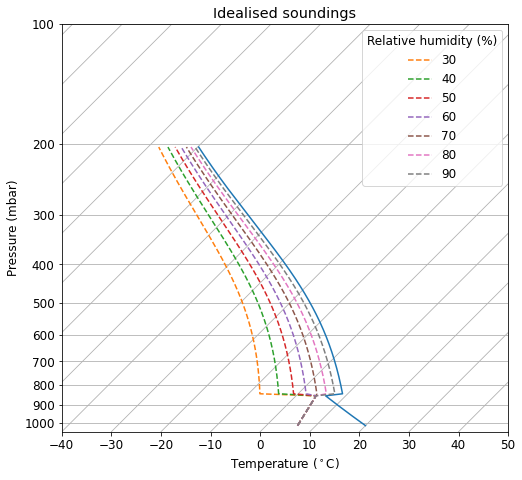

In [15]:
fig = plt.figure(figsize=(8,8))
skew = SkewT(fig, rotation=45)
sounding = idealised_sounding(0.3*units.dimensionless)
skew.plot(sounding._pressure_raw, sounding._temperature_raw)
for rh in np.arange(0.3, 0.91, 0.1)*units.dimensionless:
    sounding = idealised_sounding(rh)
    skew.plot(sounding._pressure_raw, sounding._dewpoint_raw, '--',
              label='{:.0f}'.format(rh.m*100))
lgd = skew.ax.legend()
lgd.set_title('Relative humidity (%)')
skew.ax.set(
    xlabel='Temperature ($^\circ$C)',
    ylabel='Pressure (mbar)',
    title='Idealised soundings')
plt.show()